In [34]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from glob import glob
import torch
from sklearn import metrics
import matplotlib.pyplot as plt

In [51]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [ ]:
weights_path = "/Users/jayvik/Documents/GitHub/AIML/FinalProject/run_122/best.pt"
yaml_path = "/Users/jayvik/Documents/GitHub/AIML/FinalProject/my_data/data.yaml"
images_path  = "/Users/jayvik/Documents/GitHub/AIML/FinalProject/my_data/images/test"
labels_path  = "/Users/jayvik/Documents/GitHub/AIML/FinalProject/my_data/labels/test"
model = YOLO(weights_path)
model.to(device)


def load_yolo_label_file(path):

    gt_boxes = []
    if not os.path.exists(path):
        return gt_boxes

    with open(path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            gt_boxes.append({
                "cls": int(parts[0]),
                "x": float(parts[1]),
                "y": float(parts[2]),
                "w": float(parts[3]),
                "h": float(parts[4])
            })
    return gt_boxes


def yolo_to_xyxy(box, img_w, img_h):

    xc = box["x"] * img_w
    yc = box["y"] * img_h
    w  = box["w"] * img_w
    h  = box["h"] * img_h

    x1 = xc - w/2
    y1 = yc - h/2
    x2 = xc + w/2
    y2 = yc + h/2
    return np.array([x1, y1, x2, y2])


def iou(box1, box2):

    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_w = max(xi2 - xi1, 0)
    inter_h = max(yi2 - yi1, 0)
    inter = inter_w * inter_h

    area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])

    union = area1 + area2 - inter
    return inter / union if union > 0 else 0



In [ ]:
def get_model_predictions(image_files, conf_thresh):

    all_pred_boxes = []
    all_pred_confs = []
    all_pred_cls = []

    for img_path in image_files:
        # Run inference with the specified confidence threshold
        r = model.predict(img_path, conf=conf_thresh, iou=0.5, verbose=False)[0]

        # Get the predicted boxes, confidences, and classes for this image
        pred_boxes = r.boxes.xyxy.cpu().numpy()  # Predicted bounding boxes
        pred_confs = r.boxes.conf.cpu().numpy()  # Predicted confidences
        pred_cls = r.boxes.cls.cpu().numpy().astype(int)  # Predicted class labels

        # Store predictions for this image
        all_pred_boxes.append(pred_boxes)
        all_pred_confs.append(pred_confs)
        all_pred_cls.append(pred_cls)

        #print every 50
        if len(all_pred_boxes) % 50 == 0:
            print(f"Processed {len(all_pred_boxes)} out of {len(image_files)} images")

    return all_pred_boxes, all_pred_confs, all_pred_cls



image_files = sorted(glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png")))

# Slice to only take the first N images (for testing)
#image_files = image_files[:50]  # Limit to N images

# Run inference for all images
conf_thresh = 0.001  
all_pred_boxes, all_pred_confs, all_pred_cls = get_model_predictions(image_files, conf_thresh)

# all_pred_boxes, all_pred_confs, and all_pred_cls contain the predictions for each image


Processed 50 out of 1220 images
Processed 100 out of 1220 images
Processed 150 out of 1220 images
Processed 200 out of 1220 images
Processed 250 out of 1220 images
Processed 300 out of 1220 images
Processed 350 out of 1220 images
Processed 400 out of 1220 images
Processed 450 out of 1220 images
Processed 500 out of 1220 images
Processed 550 out of 1220 images
Processed 600 out of 1220 images
Processed 650 out of 1220 images
Processed 700 out of 1220 images
Processed 750 out of 1220 images
Processed 800 out of 1220 images
Processed 850 out of 1220 images
Processed 900 out of 1220 images
Processed 950 out of 1220 images
Processed 1000 out of 1220 images
Processed 1050 out of 1220 images
Processed 1100 out of 1220 images
Processed 1150 out of 1220 images
Processed 1200 out of 1220 images


Precision: 0.8298
Recall: 0.7839
Accuracy: 0.6753
Mean IoU: 0.8513
Avg Percentage Error for Object1: 28.50%
Avg Percentage Error for Object2: 10.12%


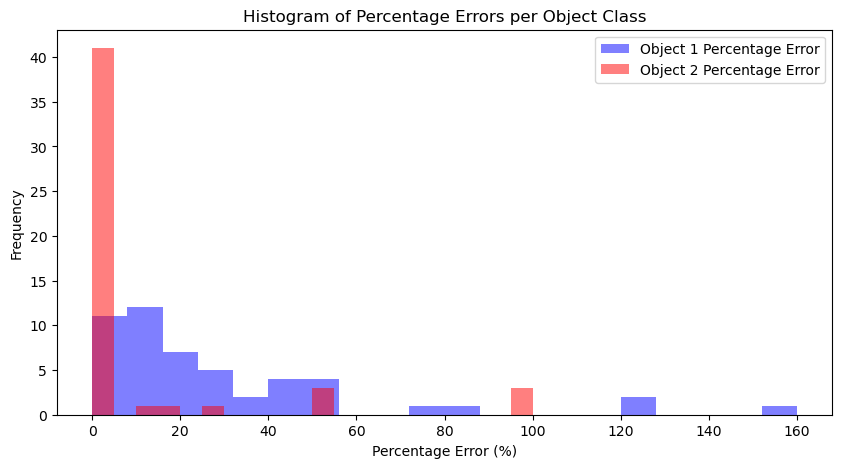

In [ ]:
def evaluate_predictions(image_files, all_pred_boxes, all_pred_confs, all_pred_cls, labels_path, conf_obj1=0.2, conf_obj2=0.2):
    TP, FP, FN = 0, 0, 0
    all_ious = []
    obj1_percentage_errors, obj2_percentage_errors = [], []

    # Loop over each image
    for idx, img_path in enumerate(image_files):
        # Load the ground truth labels
        fname = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(labels_path, fname + ".txt")
        gt = load_yolo_label_file(label_path)
        
        # Get ground truth counts for object1 (cls=0) and object2 (cls=1)
        gt_obj1_count = sum([1 for box in gt if box['cls'] == 0])
        gt_obj2_count = sum([1 for box in gt if box['cls'] == 1])
        
        # Convert GT boxes to xyxy format
        img = cv2.imread(img_path)
        H, W = img.shape[:2]
        gt_boxes_xyxy = [yolo_to_xyxy(b, W, H) for b in gt]

        # Filter predictions based on confidence threshold
        pred_boxes = all_pred_boxes[idx]
        pred_confs = all_pred_confs[idx]
        pred_cls = all_pred_cls[idx]

        filtered_boxes = []
        filtered_cls = []

        for i, cls in enumerate(pred_cls):
            if cls == 0 and pred_confs[i] >= conf_obj1:
                filtered_boxes.append(pred_boxes[i])
                filtered_cls.append(cls)
            elif cls == 1 and pred_confs[i] >= conf_obj2:
                filtered_boxes.append(pred_boxes[i])
                filtered_cls.append(cls)
        

        # Count predicted object boxes per class
        pred_obj1_count = sum([1 for cls in filtered_cls if cls == 0])
        pred_obj2_count = sum([1 for cls in filtered_cls if cls == 1])

        # Calculate percentage error for object1 and object2
        obj1_percentage_error = (abs(gt_obj1_count - pred_obj1_count) / gt_obj1_count * 100) if gt_obj1_count > 0 else 0
        obj2_percentage_error = (abs(gt_obj2_count - pred_obj2_count) / gt_obj2_count * 100) if gt_obj2_count > 0 else 0

        obj1_percentage_errors.append(obj1_percentage_error)
        obj2_percentage_errors.append(obj2_percentage_error)

        # Match predictions to GT using IoU
        matched_gt = [False] * len(gt_boxes_xyxy)

        for pb in filtered_boxes:
            best_iou = 0
            best_idx = -1
            for i, gb in enumerate(gt_boxes_xyxy):
                if matched_gt[i]:
                    continue
                current_iou = iou(pb, gb)
                if current_iou > best_iou:
                    best_iou = current_iou
                    best_idx = i
            if best_iou >= 0.5:  # If IoU > 0.5, it's a True Positive
                TP += 1
                matched_gt[best_idx] = True
                all_ious.append(best_iou)
            else:
                FP += 1

        FN += matched_gt.count(False)

    # Calculate Precision, Recall, Accuracy, and Mean IoU
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    mean_iou = np.mean(all_ious) if all_ious else 0


    return precision, recall, accuracy, mean_iou, obj1_percentage_errors, obj2_percentage_errors

Processed 50 out of 50 images


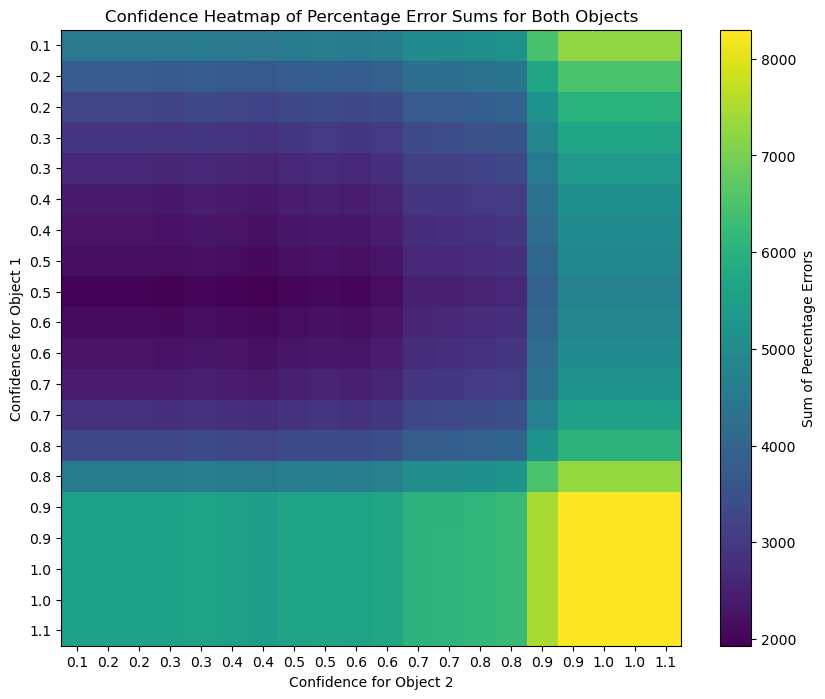

Best Confidence Thresholds - Object 1: 0.50, Object 2: 0.40


In [ ]:
# Code to find best confidence thresholds to minimize percentage error for counting using heatmap

image_files = sorted(glob(os.path.join(images_path, "*.jpg")) + glob(os.path.join(images_path, "*.png")))
image_files = image_files[:50]  # Limit to N images

# Run inference for all images
conf_thresh = 0.001 
subset_pred_boxes, subset_pred_confs, subset_pred_cls = get_model_predictions(image_files, conf_thresh)

conf_thresholds = np.arange(0.1, 1.1, 0.05)

error_heatmap = np.zeros((len(conf_thresholds), len(conf_thresholds)))

# Loop over all combinations of confidence thresholds
for i, conf_obj1 in enumerate(conf_thresholds):
    for j, conf_obj2 in enumerate(conf_thresholds):
        # Run the evaluation function for each combination of confidence thresholds
        precision, recall, accuracy, mean_iou, obj1_errors, obj2_errors = evaluate_predictions(
            image_files, subset_pred_boxes, subset_pred_confs, subset_pred_cls, labels_path,
            conf_obj1=conf_obj1, conf_obj2=conf_obj2
        )

        # Store the sum of percentage errors (you can use other statistics if you prefer)
        error_heatmap[i, j] = np.sum(obj1_errors) + np.sum(obj2_errors)

# Plot the 100x100 heatmap of percentage error sums
plt.figure(figsize=(10, 8))
plt.imshow(error_heatmap, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Sum of Percentage Errors')
plt.xticks(np.arange(len(conf_thresholds)), [f'{x:.1f}' for x in conf_thresholds])
plt.yticks(np.arange(len(conf_thresholds)), [f'{x:.1f}' for x in conf_thresholds])
plt.xlabel('Confidence for Object 2')
plt.ylabel('Confidence for Object 1')
plt.title('Confidence Heatmap of Percentage Error Sums for Both Objects')
plt.show()



min_error_idx = np.unravel_index(np.argmin(error_heatmap), error_heatmap.shape)
best_conf_obj1 = conf_thresholds[min_error_idx[0]]
best_conf_obj2 = conf_thresholds[min_error_idx[1]]
print(f"Best Confidence Thresholds - Object 1: {best_conf_obj1:.2f}, Object 2: {best_conf_obj2:.2f}")

Precision: 0.8310
Recall: 0.7831
Accuracy: 0.6755
Mean IoU: 0.8515
Avg Percentage Error for Object1: 28.50%
Avg Percentage Error for Object2: 13.12%


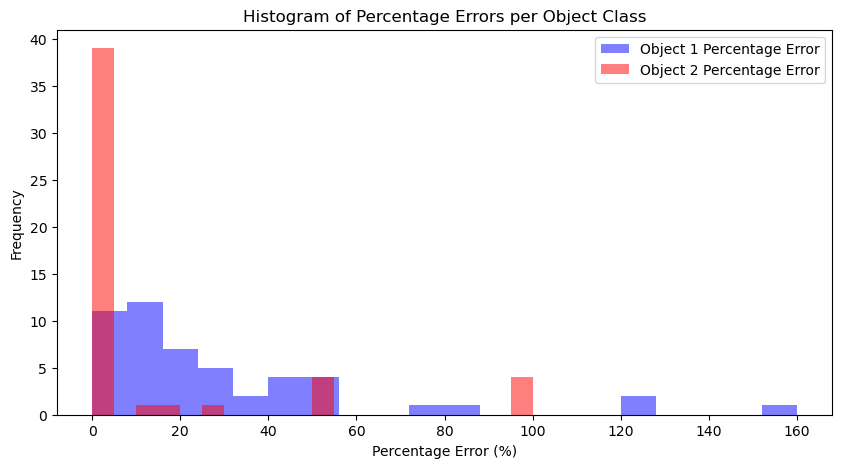

: 

In [ ]:
precision, recall, accuracy, mean_iou, obj1_errors, obj2_errors = evaluate_predictions(
    image_files, subset_pred_boxes, subset_pred_confs, subset_pred_cls, labels_path, conf_obj1=0.5, conf_obj2=0.5
    )

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Avg Percentage Error for Object1: {np.mean(obj1_errors):.2f}%")
print(f"Avg Percentage Error for Object2: {np.mean(obj2_errors):.2f}%")

plt.figure(figsize=(10, 5))
plt.hist(obj1_errors, bins=20, alpha=0.5, label='Object 1 Percentage Error', color='blue')
plt.hist(obj2_errors, bins=20, alpha=0.5, label='Object 2 Percentage Error', color='red')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Percentage Errors per Object Class')
plt.legend()
plt.show()